## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

In [2]:
from random import sample
import sklearn.model_selection as skl
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda, AvgPool2D
from keras.models import Model
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
import math

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [3]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
80088,00019677_000.png,Effusion,0,19677,38,F,PA,2882,2869,0.143,0.143,NaN,/data/images_009/images/00019677_000.png
75050,00018404_008.png,No Finding,8,18404,69,F,AP,2500,2048,0.168,0.168,NaN,/data/images_009/images/00018404_008.png
30886,00008043_006.png,No Finding,6,8043,63,F,PA,2810,2989,0.143,0.143,NaN,/data/images_004/images/00008043_006.png


In [4]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Reference
# https://www.kaggle.com/kmader/train-simple-xray-cnn

all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
39415,00010327_000.png,Atelectasis,0,10327,65,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60926,00015039_010.png,Infiltration,10,15039,46,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
63798,00015741_001.png,,1,15741,72,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[Text(0, 0.5, 'Number of Images with Label')]

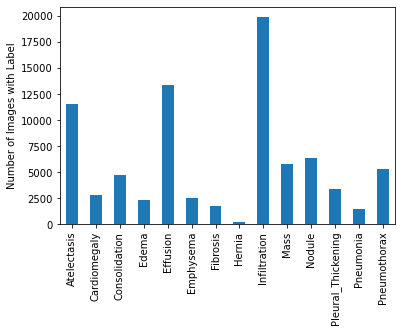

In [5]:
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

In [6]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['pneumonia_class']=all_xray_df['Pneumonia'].apply(int).apply(str)
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
63706,00015721_009.png,Atelectasis,9,15721,44,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
101293,00026908_004.png,Consolidation,4,26908,63,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
85328,00021035_012.png,Effusion|Infiltration|Nodule,12,21035,34,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0


In [7]:
all_xray_df['pneumonia_class'].value_counts()

0    110689
1      1431
Name: pneumonia_class, dtype: int64

#### The data is imbalanced

## Create your training and testing data:

In [8]:
def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    
    train_data, val_data = skl.train_test_split(vargs, 
                                   test_size = 0.2, 
                                   stratify = vargs['pneumonia_class'])
    
    p_inds=train_data[train_data['pneumonia_class']=='1'].index.tolist()
    np_inds=train_data[train_data['pneumonia_class']=='0'].index.tolist()
    np_sample = sample(np_inds,len(p_inds))
    train_data = train_data.loc[p_inds + np_sample]
    
    v_p_inds=val_data[val_data['pneumonia_class']=='1'].index.tolist()
    v_np_inds=val_data[val_data['pneumonia_class']=='0'].index.tolist()
    v_np_sample = sample(v_np_inds,4*len(v_p_inds))
    val_data = val_data.loc[v_p_inds + v_np_sample]
    
    return train_data, val_data

In [9]:
train_df,val_df=create_splits(all_xray_df)

In [10]:
train_df['pneumonia_class'].astype('int').sum()/len(train_df)

0.5

We randomly chose a set of  pneumonia_class images using the sample() function that was the same length as the number of true pneumonia_class cases we had, and then we threw out the rest of the non pneumonia_class cases. Now our training dataset is balanced 50-50

In [11]:
val_df['pneumonia_class'].astype('int').sum()/len(val_df)

0.2

##### Our validation set more like 20-80 

In [12]:
print(f'Train set size: {len(train_df)}, valid set size: {len(val_df)}')

Train set size: 2290, valid set size: 1430


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [13]:
IMG_SIZE = (512, 512) # slightly smaller than vgg16 normally expects

In [14]:
def my_image_augmentation(**vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    
    my_idg = ImageDataGenerator(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip=False, 
                              vertical_flip=False, 
                              height_shift_range=0.1, 
                              width_shift_range=0.1, 
                              brightness_range=[0.7, 1.5],
                              rotation_range=3, 
                              shear_range=0.01,
                              fill_mode='nearest',
                              zoom_range=0.125,
                              preprocessing_function=preprocess_input)
    
    return my_idg


def make_train_gen(**vargs):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    my_train_idg = my_image_augmentation(**vargs)
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                          x_col ='path',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size = IMG_SIZE, 
                                          batch_size = 256 
                                         )
     # Todo

    return train_gen


def make_val_gen(**vargs):
    my_val_idg = my_image_augmentation(**vargs)
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_df, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = IMG_SIZE, 
                                             batch_size = 1024) 
    
    # Todo
    return val_gen

In [15]:
train_gen = make_train_gen()
val_gen = make_val_gen()

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [16]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

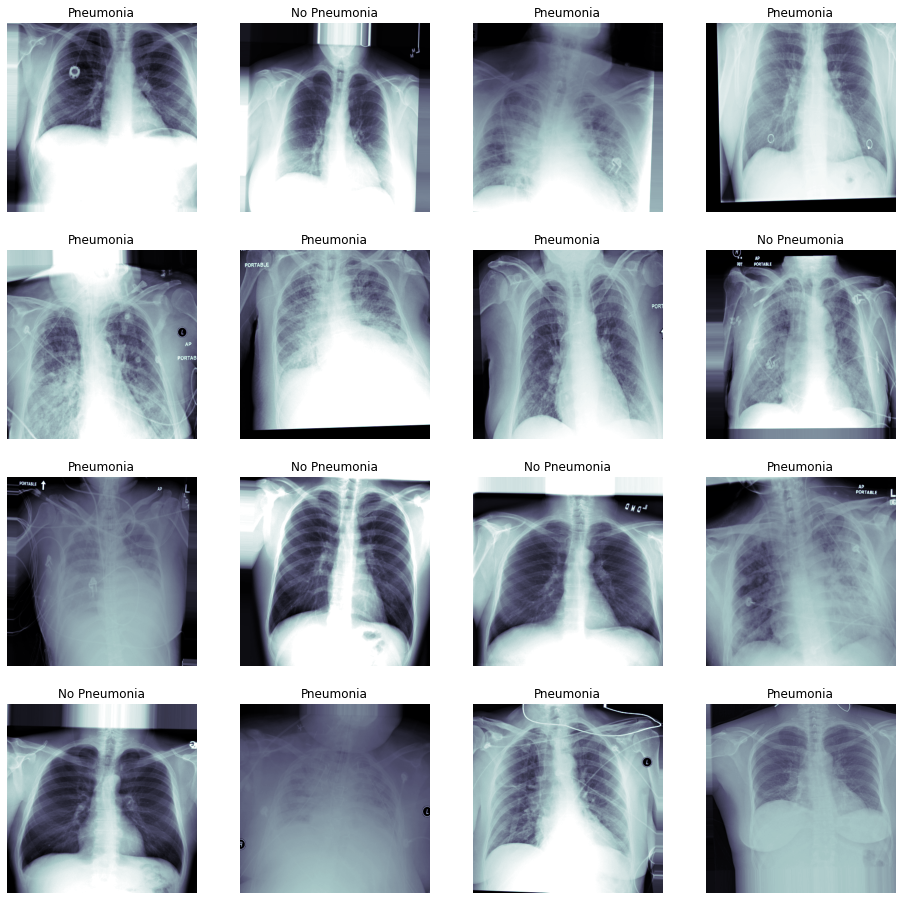

In [17]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

### Model
* https://www.kaggle.com/kmader/cardiomegaly-pretrained-vgg16

In [25]:


def build_my_model():
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], 
                              include_top = False, weights = 'imagenet')
    base_pretrained_model.trainable = False
    pt_features = Input(base_pretrained_model.get_output_shape_at(0)[1:], name = 'feature_input')
    pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
    
    bn_features = BatchNormalization(name='Features_BN')(pt_features)
    attn_layer = Conv2D(128, kernel_size = (1,1), padding = 'same', activation = 'elu')(bn_features)
    attn_layer = Conv2D(32, kernel_size = (1,1), padding = 'same', activation = 'elu')(attn_layer)
    attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'elu')(attn_layer)
    attn_layer = AvgPool2D((2,2), strides = (1,1), padding = 'same')(attn_layer) # smooth results
    attn_layer = Conv2D(1, 
                    kernel_size = (1,1), 
                    padding = 'valid', 
                    activation = 'sigmoid',
                   name='AttentionMap2D')(attn_layer)
    # fan it out to all of the channels
    up_c2_w = np.ones((1, 1, 1, pt_depth))
    up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', name='UpscaleAttention',
               activation = 'linear', use_bias = False, weights = [up_c2_w])
    up_c2.trainable = False
    attn_layer = up_c2(attn_layer)
    mask_features = multiply([attn_layer, bn_features])
    gap_features = GlobalAveragePooling2D()(mask_features)
    gap_mask = GlobalAveragePooling2D()(attn_layer)
    # to account for missing values from the attention model
    gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
    gap_dr = Dropout(0.5)(gap)
    dr_steps = Dropout(0.5)(Dense(128, activation = 'elu')(gap_dr))
    out_layer = Dense(1, activation = 'sigmoid')(dr_steps)

    attn_model = Model(inputs = [pt_features], outputs = [out_layer], name = 'attention_model')

    attn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy'])
    tb_model = Sequential(name = 'combined_model')
    base_pretrained_model.trainable = False
    tb_model.add(base_pretrained_model)
    tb_model.add(attn_model)
    tb_model.compile(optimizer = Adam(lr = 1e-3), loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy'])    
    return tb_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [26]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=5)

callbacks_list = [checkpoint, early]

### Start training! 

In [29]:
## build_my_model_1

my_model = build_my_model()
train_gen.batch_size = 24
my_model.fit_generator(train_gen, 
                      validation_data = (valX, valY), 
                       steps_per_epoch=train_gen.n//train_gen.batch_size,
                      epochs = 1, 
                      callbacks = callbacks_list,
                      workers = 3)

Epoch 1/1
95/95 [==============================] - 214s 2s/step - loss: 0.6899 - binary_accuracy: 0.5790 - val_loss: 0.6253 - val_binary_accuracy: 0.6553

Epoch 00001: val_loss improved from inf to 0.62535, saving model to xray_class_my_model.best.hdf5


In [30]:
## train your model

# Todo

history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                       steps_per_epoch=train_gen.n//train_gen.batch_size,
                      epochs = 10, 
                      callbacks = callbacks_list,
                      workers = 3)

Epoch 1/10
95/95 [==============================] - 191s 2s/step - loss: 0.6688 - binary_accuracy: 0.6055 - val_loss: 0.6603 - val_binary_accuracy: 0.6318

Epoch 00001: val_loss did not improve from 0.62535
Epoch 2/10
95/95 [==============================] - 191s 2s/step - loss: 0.6605 - binary_accuracy: 0.6218 - val_loss: 0.6116 - val_binary_accuracy: 0.6777

Epoch 00002: val_loss improved from 0.62535 to 0.61159, saving model to xray_class_my_model.best.hdf5
Epoch 3/10
95/95 [==============================] - 191s 2s/step - loss: 0.6403 - binary_accuracy: 0.6359 - val_loss: 0.6300 - val_binary_accuracy: 0.6475

Epoch 00003: val_loss did not improve from 0.61159
Epoch 4/10
95/95 [==============================] - 190s 2s/step - loss: 0.6452 - binary_accuracy: 0.6390 - val_loss: 0.7219 - val_binary_accuracy: 0.5508

Epoch 00004: val_loss did not improve from 0.61159
Epoch 5/10
95/95 [==============================] - 190s 2s/step - loss: 0.6471 - binary_accuracy: 0.6346 - val_loss: 0.6

KeyboardInterrupt: 

### The model is overfitting